# Hospital Interaction Network

This notebook is used to:
- train a GNN over the HIN dataset
- extract local explanations with PGExplainer 

In [1]:
import random
import pandas as pd
import pickle as pkl
import networkx as nx
import numpy as np
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csr_matrix

import torch
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.utils import to_networkx, from_networkx, to_dense_adj
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv,global_max_pool,global_add_pool,global_mean_pool, GATConv
from torch_geometric.loader import DataLoader
from torch.nn import Linear

from graphxai.explainers.pg_explainer import *

random.seed(10)
device = "cpu"

## load dataset

In [2]:
class HIN(InMemoryDataset):
    def __init__(self, transform=None, pre_filter=None):
        super().__init__('.',transform,pre_filter)

        with open('HIN.pkl','rb') as fin:
            (adjs, feas, labels) = pkl.load(fin)

        data_list = []
        counts = defaultdict(int)
        for i in range(len(adjs)):
            num_nodes = len(adjs[i][0])
            adj = adjs[i]
            g = nx.from_numpy_array(adj)            
            tmp_data = from_networkx(g)

            fea = feas[i]
            label = labels[i]
            
            counts[label] += 1
            edge_index = tmp_data.edge_index

            data = Data(x=torch.tensor(fea,dtype=torch.float), edge_index=edge_index, y=label)
            data_list.append(data)

        self.data, self.slices = self.collate(data_list)

## Define a GNN

In [3]:
class Net(torch.nn.Module):
    def __init__(self, num_in_features, num_classes, hidden_dim=20):
        super().__init__()
        self.conv1 = GCNConv(num_in_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.lin1 = Linear(hidden_dim, int(hidden_dim/2))
        self.lin2 = Linear(int(hidden_dim/2), num_classes)

    def forward(self, x, edge_index, batch=None, edge_mask=None):
        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=edge_index.device)

        x = F.relu(self.conv1(x, edge_index, edge_mask))
        x = F.relu(self.conv2(x, edge_index, edge_mask))
        x = F.relu(self.conv3(x, edge_index, edge_mask))

        x = global_max_pool(x,batch)

        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=-1)

In [4]:
def train(train_loader):   
    model.train()
    optimizer.zero_grad()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(model, loader, preds=None, trues=None):
    model.eval()

    total_correct = 0
    total_loss = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        total_correct += int((out.argmax(-1) == data.y).sum())
        
        if preds is not None:
            preds.extend(out.argmax(-1).cpu().numpy().tolist())
            trues.extend(data.y.cpu().numpy().tolist())

        loss = F.nll_loss(out, data.y)
        total_loss += float(loss) * data.num_graphs
    return total_correct / len(loader.dataset) , total_loss / len(train_loader.dataset)

## Train the GNN

In [5]:
dataset = HIN()
model = Net(num_in_features=5, num_classes=dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_idx, test_idx = train_test_split(torch.arange(len(dataset)), train_size=0.8, stratify=dataset.data.y, random_state=10)
val_idx, test_idx   = train_test_split(test_idx, train_size=0.4, stratify=dataset.data.y[test_idx], random_state=10)

train_loader = DataLoader(dataset[train_idx], batch_size=128)
val_loader   = DataLoader(dataset[val_idx], batch_size=512)
test_loader  = DataLoader(dataset[test_idx], batch_size=512)

In [ ]:
best_model , best_acc = None , 0
for epoch in range(0, 1000):
    loss = train(train_loader)
    train_acc , train_loss = test(model, train_loader)
    val_acc , val_loss = test(model, test_loader)
    test_acc , test_loss = test(model, test_loader)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.3f}, Test Loss: {test_loss:.3f}, Train Acc: {train_acc:.3f} '
        f'Test Acc: {test_acc:.3f} Val Acc: {val_acc:.3f}')
    if best_acc < val_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model)

## Evaluate Model

In [6]:
preds , trues = [] , []

#model = best_model

model = Net(5,dataset.num_classes).to(device)
model.load_state_dict(torch.load("trained_model_hin.pt"))

model.eval()
test_acc,test_loss = test(model, train_loader, preds , trues)
print("GNN Accuracy: ", test_acc)

#from sklearn.metrics import confusion_matrix
#confusion_matrix(trues, preds)

GNN Accuracy:  0.9154829545454546


## PGExplainer

In [7]:
def convert_labels(g):
    new_dict = dict()
    for n,x in dict(nx.get_node_attributes(g,"x")).items():
        if x[0]==1:
            new_dict[n]="M"
        if x[1]==1:
            new_dict[n]="P"
        if x[2]==1:
            new_dict[n]="A"
        if x[3]==1:
            new_dict[n]="N"
        if x[4]==1:
            new_dict[n]="Ego"
    return new_dict

def plot(adj, label, graphid, masked_adj, only_important_edges, ax=None, cut=None, g=None):
    after_adj_dense = masked_adj
    after_adj = coo_matrix(after_adj_dense)
    rcd = np.concatenate(
        [np.expand_dims(after_adj.row, -1), np.expand_dims(after_adj.col, -1), np.expand_dims(after_adj.data, -1)], -1)
    pos_edges = []
    filter_edges = []

    edge_weights = np.triu(after_adj_dense).flatten()
    sorted_weights = sorted(edge_weights, reverse=True)
    if cut is None:
        thres = elbow_method(edge_weights, min_num_include=2)
    else:
        thres = cut

    important_nodes = set()
    for r, c, d in rcd:
        if r<c:
            continue
        if d >= thres:
            pos_edges.append((int(r), int(c)))
            important_nodes.add(r)
            important_nodes.add(c)
        filter_edges.append((r, c))
    
    dic = convert_labels(g)
    ego_node = next(iter({i for i in dic if dic[i] == "Ego"}))
    if ego_node not in important_nodes:
        return False

    G3 = nx.from_numpy_matrix(adj)
    colors = ['orange', 'lime', 'red', 'blue', 'maroon', 'brown', 'darkslategray', 'paleturquoise', 'darksalmon',
              'slategray', 'mediumseagreen', 'mediumblue', 'orchid']
    
    def myfilter(u,v,other=None):
        if (u,v) in pos_edges or (v,u) in pos_edges:
            return True
        return False
    
    def myfilter2(n):
        for (u,v) in pos_edges:
            if u == n or v == n:
                return True
        return False    
    
    ccs = list(nx.connected_components(nx.subgraph_view(G3, filter_node=myfilter2, filter_edge=myfilter)))
    for cc in ccs:
        if ego_node in cc:
            found = True
            G = nx.subgraph_view(G3, filter_node=myfilter2,filter_edge=myfilter).subgraph(cc)
    if not found:
        return False
    pos = nx.kamada_kawai_layout(G3)
    
    # nodes
    nmb_nodes = after_adj_dense.shape[0]
    node_filter = []
    for node in range(nmb_nodes):
        if node in G3.nodes():
            node_filter.append(node)

    pos_edges = [(u,v) for u,v in pos_edges if (u,v) in G.edges()]
    node_list = node_filter if not only_important_edges else list(important_nodes)
    nx.draw_networkx_nodes(G3, pos, ax=ax,
                           nodelist=node_list,
                           node_color=colors[0],
                           node_size=500)
    if not only_important_edges:
        nx.draw_networkx_edges(G3, pos, width=2, ax=ax, edge_color='grey')
    nx.draw_networkx_edges(G3, pos, ax=ax,
                           edgelist=pos_edges,
                           width=4 if not only_important_edges else 2)
    nx.draw_networkx_labels(G3, pos, {k:v for k,v in convert_labels(g).items() if k in G3.nodes()}, font_size=18, font_color="black", ax=ax)
    return True

def elbow_method(weights, index_stopped=None, min_num_include=2):
    sorted_weights = sorted(weights, reverse=True)
    sorted_weights = np.convolve(sorted_weights, np.ones(min_num_include), 'valid') / min_num_include
    stop = np.mean(sorted_weights) # backup threshold
    for i in range(len(sorted_weights)-2):
        if i < min_num_include:
            continue
        if sorted_weights[i-1] - sorted_weights[i] > 0.0:
            if sorted_weights[i-1] - sorted_weights[i] >= 40 * (sorted_weights[0] - sorted_weights[i-2]) / 100 + (sorted_weights[0] - sorted_weights[i-2]):
                stop = sorted_weights[i]
                if index_stopped is not None:
                    index_stopped.append(i)
                break
    return stop


def plot_etn(data, ax=None):
    G = to_networkx(data, node_attrs=["x"], to_undirected=True)
    pos = nx.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color="orange", node_size=400, ax=ax)
    nx.draw_networkx_labels(G, pos, {k:v for k,v in convert_labels(G).items() if k in G.nodes()}, font_size=18, font_color="black", ax=ax)

def plot_k_per_class(k, only_important_edges=False):
    figsize = (25, 15)
    cols = k
    rows = 2

    axs = plt.figure(figsize=figsize, constrained_layout=True).subplots(rows, cols)
    for i in range(rows):
        for j in range(cols):
            axs[i, j].axis("off")    
    for i in range(rows):
        added = 0
        idxs = torch.nonzero(dataset.data.y == i).squeeze()[:][torch.randperm(100)]
        for j , idx in enumerate(idxs):
            ret = explainer.get_explanation_graph(dataset[idx].x.to(device), 
                                                  dataset[idx].edge_index.to(device), 
                                                  label=dataset[idx].y.to(device))
            adj = to_dense_adj(dataset[idx].edge_index.cpu()).squeeze(0).numpy()
            masked_adj = to_dense_adj(dataset[idx].edge_index.cpu(), edge_attr=ret.edge_imp.cpu()).squeeze(0)
            
            g = to_networkx(dataset[idx], node_attrs=["x"])
            is_added = plot(adj, 
                             dataset[idx].y, 
                             -1, 
                             masked_adj, 
                             ax=axs[i,added],
                             cut=None,
                             only_important_edges=only_important_edges,
                             g=g)
            if is_added:
                added +=1
                if added == 3:
                    axs[i,added].set_title(f"Class {i}", size=30)
            if added == cols:
                break
    plt.show()

In [134]:
explainer = PGExplainer(model, explain_graph=True, emb_layer_name="conv3", t0=1, t1=1, device="cpu", max_epochs=30)
#explain_idx = train_idx[train_preds == train_trues]
explainer.train_explanation_model(dataset[train_idx]) 

100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 116.40it/s]


Epoch: 0 | Loss: 622.2394963502884


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 110.62it/s]


Epoch: 1 | Loss: 615.6346752047539


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 116.27it/s]


Epoch: 2 | Loss: 609.146879196167


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 115.32it/s]


Epoch: 3 | Loss: 602.7989959716797


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 116.54it/s]


Epoch: 4 | Loss: 596.5446772277355


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 116.15it/s]


Epoch: 5 | Loss: 590.3155545145273


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 116.53it/s]


Epoch: 6 | Loss: 584.0906871184707


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 114.65it/s]


Epoch: 7 | Loss: 577.8953659161925


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 111.60it/s]


Epoch: 8 | Loss: 571.7719126567245


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 110.29it/s]


Epoch: 9 | Loss: 565.742285437882


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 118.39it/s]


Epoch: 10 | Loss: 559.8477095663548


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 116.57it/s]


Epoch: 11 | Loss: 554.0868986919522


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 117.35it/s]


Epoch: 12 | Loss: 548.4475015923381


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 117.93it/s]


Epoch: 13 | Loss: 542.9394391477108


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 115.41it/s]


Epoch: 14 | Loss: 537.5758343935013


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 113.14it/s]


Epoch: 15 | Loss: 532.3636983558536


100%|██████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:13<00:00, 93.19it/s]


Epoch: 16 | Loss: 527.3230079710484


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 113.21it/s]


Epoch: 17 | Loss: 522.4818968996406


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:10<00:00, 115.59it/s]


Epoch: 18 | Loss: 517.8676157742739


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 113.84it/s]


Epoch: 19 | Loss: 513.513997592032


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:12<00:00, 102.69it/s]


Epoch: 20 | Loss: 509.4550094306469


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 108.02it/s]


Epoch: 21 | Loss: 505.70662562549114


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 110.84it/s]


Epoch: 22 | Loss: 502.2900169491768


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 110.19it/s]


Epoch: 23 | Loss: 499.20381785184145


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 108.18it/s]


Epoch: 24 | Loss: 496.4417763352394


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 113.06it/s]


Epoch: 25 | Loss: 493.99647314846516


100%|█████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:11<00:00, 107.44it/s]


Epoch: 26 | Loss: 491.8462033420801


100%|██████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:14<00:00, 86.04it/s]


Epoch: 27 | Loss: 489.96880296617746


100%|██████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:14<00:00, 85.12it/s]


Epoch: 28 | Loss: 488.337145678699


100%|██████████████████████████████████████████████████████████████████████████████| 1262/1262 [00:14<00:00, 88.13it/s]

Epoch: 29 | Loss: 486.92556911706924


In [8]:
#torch.save(explainer.elayers.state_dict(), "pgexpl_etn_not1t2_val_643.pt")
explainer = PGExplainer(model, explain_graph=True, emb_layer_name="conv3", t0=1, t1=1, device="cpu", max_epochs=20)
explainer.elayers.load_state_dict(torch.load("pgexpl_etn_not1t2_val_643.pt"))
explainer.elayers.eval()

ModuleList(
  (0): Sequential(
    (0): Linear(in_features=40, out_features=64, bias=True)
    (1): ReLU()
  )
  (1): Linear(in_features=64, out_features=1, bias=True)
)

## Inspect Explanations

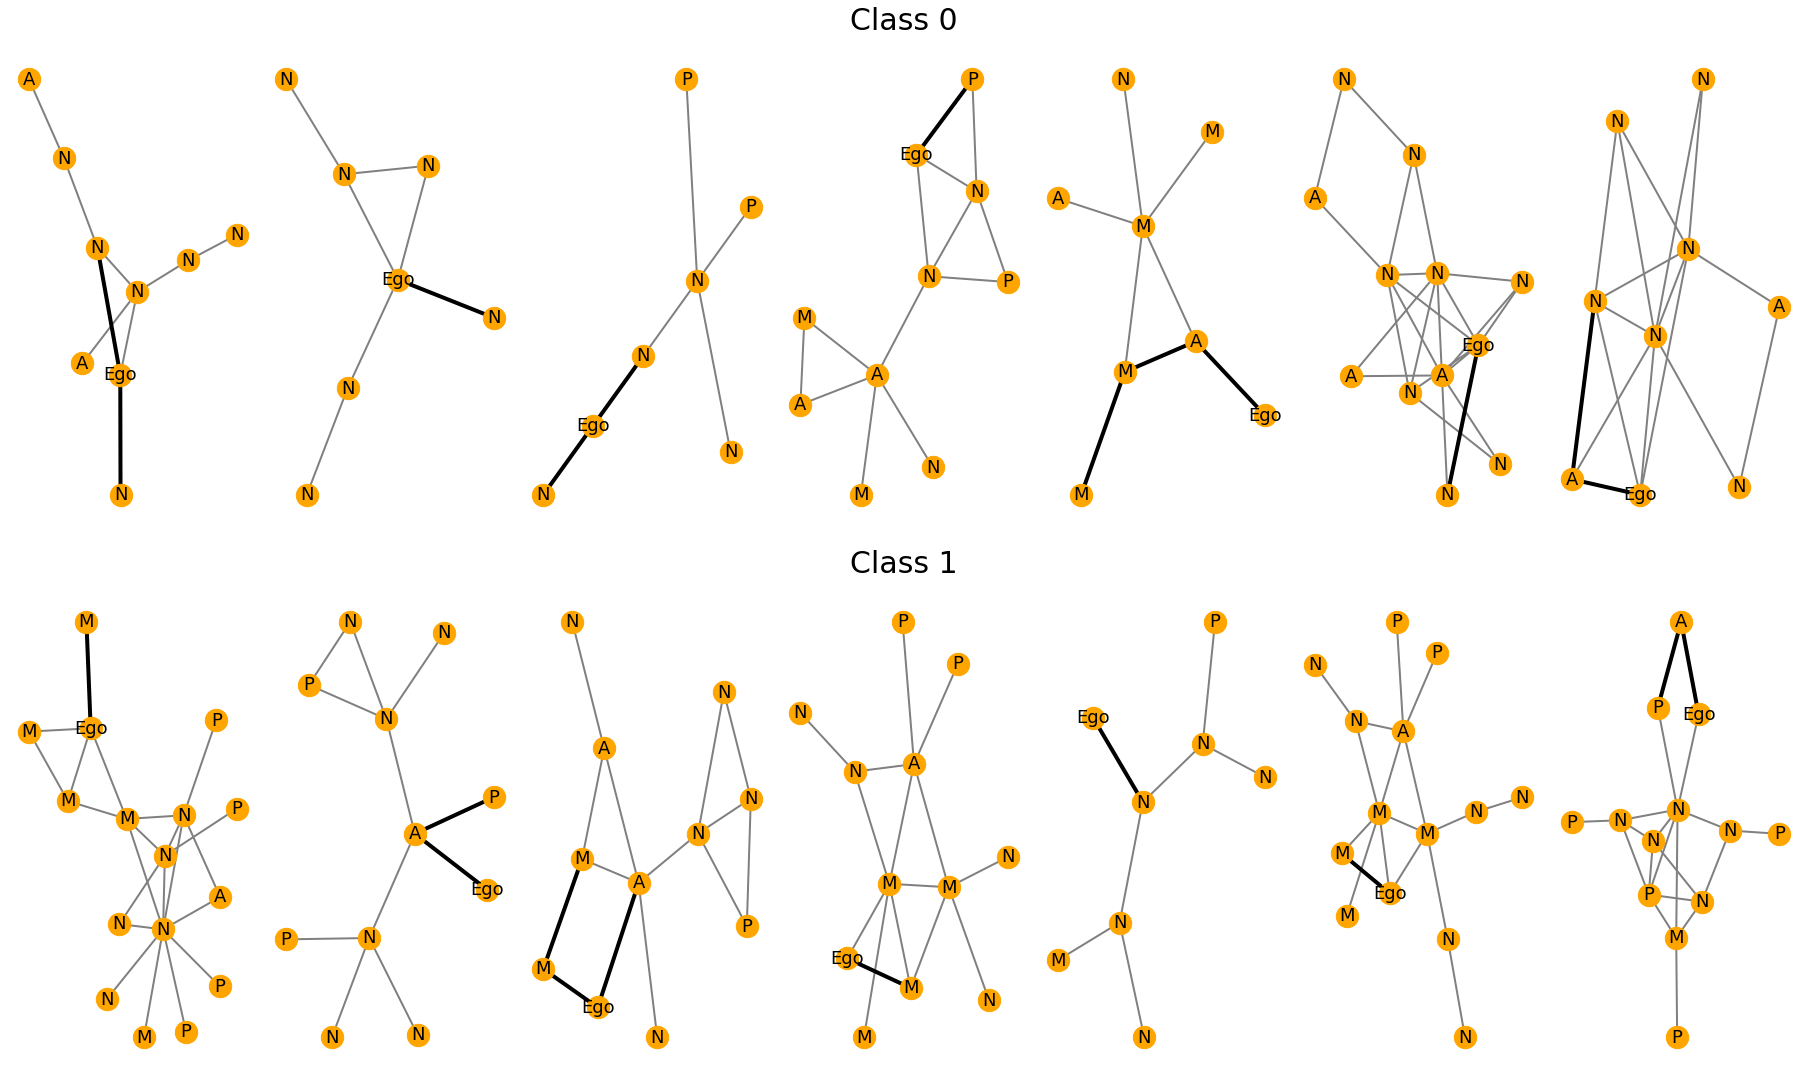

In [14]:
device = "cpu"
plot_k_per_class(7, only_important_edges=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1408/1408 [00:18<00:00, 76.53it/s]


750


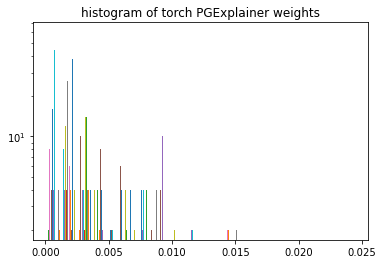

In [13]:
explain_idx = train_idx

weights = []
sa = 0
for i in tqdm.tqdm(range(len(dataset[explain_idx]))):
    ret = explainer.get_explanation_graph(dataset[explain_idx][i].x.to(device), 
                                          dataset[explain_idx][i].edge_index.to(device), 
                                          label=dataset[explain_idx][i].y.to(device))
    masked = to_dense_adj(dataset[explain_idx][i].edge_index.cpu(), edge_attr=ret.edge_imp.cpu()).squeeze(0)
    cut = elbow_method(np.triu(masked).flatten(), min_num_include=2)
    
    masked[masked < cut] = 0
    masked[masked >= cut] = 1   
    G = nx.from_numpy_matrix(masked.numpy())
    connected_components = list(nx.connected_components(G))
    ego_node = int(np.argmax(dataset[explain_idx][i].x[:, 4] == 1))
    for cc in connected_components:
        if len(cc) >= 2 and ego_node in cc:
            sa += 1

    weights.append(ret.edge_imp.cpu().numpy().tolist())
print(sa)
plt.hist(weights, bins=20, log=True);
plt.title("histogram of torch PGExplainer weights");

## Save Local Explanations

Before saving, create the proper folder structure following the other examples

In [136]:
path = f"../../local_explanations/PGExplainer/HIN/GCN"

for gid in range(len(dataset)):
    c = dataset[gid].y
    c_pred = model(dataset[gid].x, dataset[gid].edge_index, None).argmax(-1).item()
    
    partition = None
    if gid in train_idx:
        partition = "TRAIN"
    elif gid in val_idx:
        partition = "VAL"
    else:
        partition = "TEST"
        
    ret = explainer.get_explanation_graph(dataset[gid].x.to(device), 
                                          dataset[gid].edge_index.to(device), 
                                          label=dataset[gid].y.to(device))
    masked_adj = to_dense_adj(dataset[gid].edge_index.cpu(), edge_attr=ret.edge_imp.cpu()).squeeze(0)
    to_save = masked_adj.numpy()
    with open(f'{path}/{partition}/{c.item()}/{c_pred}_{gid}.pkl', 'wb') as f:
        pkl.dump(to_save, f)
    with open(f'{path}/{partition}/features/{c_pred}_{gid}.pkl', 'wb') as f:
        pkl.dump(dataset[gid].x, f)